Loaded rows: 8652
Selected features: ['pps_asset', 'pps_premium_pct', 'pct_chg_1m', 'pct_chg_3m', 'pct_chg_12m', 'volatility', 'nearest_dist_km', 'latitude_z', 'longitude_z', 'log_rentable_sqft', 'age', 'utilization', 'is_owned']
Rows kept for clustering: 8652
k=3 silhouette=0.2127
k=4 silhouette=0.2317
k=5 silhouette=0.2202
k=6 silhouette=0.2320
Selected k = 6
Saved cluster assignments to asset_clusters_with_macro.csv

Cluster profiles:
 macro_cluster     pps_asset  pps_premium_pct  pct_chg_12m  log_rentable_sqft       age  utilization  is_owned  nearest_dist_km  n_assets                       cluster_name
             0    657.348736        -0.998287    -0.002406           0.246907 30.553366          1.0  0.287218         4.926863       665    Mid Value · Stable · Peripheral
             1     83.943291        -0.999746     0.021428           9.151984 23.884651          1.0  0.010507         4.564112      4283   Mid Value · Growing · Peripheral
             2    125.584482        -0.

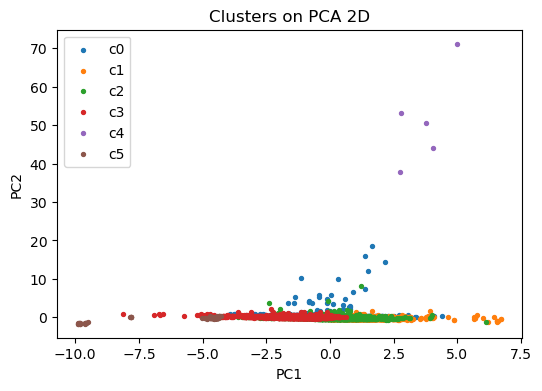

In [11]:
# Unsupervised clustering for asset classes
# Save this file as unsupervised_clustering_assets.py or paste into a notebook cell.
# It assumes your CSV (Task 1 results) is at /mnt/data/assets_with_model_predictions.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ============ PARAMETERS ============
CSV_PATH = r'C:\Users\salon\OneDrive\Desktop\Task 2\assets_with_model_predictions.xlsx'
OUT_CSV = 'asset_clusters_with_macro.csv'
USE_SILHOUETTE = True       # if True, test k in K_RANGE
K_RANGE = list(range(3,7))  # tested values for k
FINAL_K = None              # if set, will override silhouette and use this
RANDOM_STATE = 42

# ============ LOAD ============
df = pd.read_excel(CSV_PATH, engine='openpyxl')
print('Loaded rows:', df.shape[0])

# ============ FEATURE ENGINEERING ============
# 1) clean numeric columns and create price-per-sqft (pps_asset)
df['target_price'] = pd.to_numeric(df.get('target_price'), errors='coerce')
df['predicted_price_model'] = pd.to_numeric(df.get('predicted_price_model'), errors='coerce')
df['estimated_price'] = pd.to_numeric(df.get('estimated_price'), errors='coerce')

# ensure rentable sqft exists
sqft_col = 'building rentable square feet'
df[sqft_col] = pd.to_numeric(df.get(sqft_col), errors='coerce').fillna(0)

# pps_asset: try target_price -> predicted_price_model -> estimated_price
pps = df['target_price'] / df[sqft_col].replace(0, np.nan)
pps = pps.fillna(df['predicted_price_model'] / df[sqft_col].replace(0, np.nan))
pps = pps.fillna(df['estimated_price'] / max(1, df[sqft_col].median()))
df['pps_asset'] = pps

# 2) price premium vs region (if region price exists)
if 'price_latest_reg' in df.columns:
    df['price_latest_reg'] = pd.to_numeric(df['price_latest_reg'], errors='coerce')
    mask = df['price_latest_reg'].notnull() & (df['price_latest_reg']!=0)
    df.loc[mask, 'pps_premium_pct'] = (df.loc[mask,'pps_asset'] - df.loc[mask,'price_latest_reg']) / df.loc[mask,'price_latest_reg']
else:
    df['pps_premium_pct'] = np.nan

# 3) size & utilization
df['available square feet'] = pd.to_numeric(df.get('available square feet'), errors='coerce').fillna(0)
df['vacancy_rate'] = (df['available square feet'] / df[sqft_col].replace(0, np.nan)).clip(0,1).fillna(0)
df['utilization'] = 1 - df['vacancy_rate']
df['log_rentable_sqft'] = np.log1p(df[sqft_col].clip(lower=0))

# 4) age
def safe_year(x):
    try:
        return pd.to_datetime(x, errors='coerce').year
    except:
        return np.nan

# ✅ Fix age calculation
CURRENT_YEAR = 2024

if 'construction date' in df.columns:
    df['age'] = CURRENT_YEAR - df['construction date']

    # Handle anomalies
    df.loc[df['age'] < 0, 'age'] = np.nan  
    df.loc[df['age'] > 120, 'age'] = 120  
else:
    df['age'] = np.nan

# 5) volatility and trends
for c in ['vol_12m','vol_6m','trend_6m','trend_12m','pct_chg_1m','pct_chg_3m','pct_chg_12m']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)
if 'vol_12m' in df.columns:
    df['volatility'] = np.log1p(df['vol_12m'].fillna(0))
else:
    df['volatility'] = 0

# 6) coords
if 'latitude' in df.columns and 'longitude' in df.columns:
    df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
    df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
    df['latitude_z'] = (df['latitude'] - df['latitude'].mean())/df['latitude'].std()
    df['longitude_z'] = (df['longitude'] - df['longitude'].mean())/df['longitude'].std()
else:
    df['latitude_z'] = 0
    df['longitude_z'] = 0

# 7) ownership and asset type
df['owned_or_leased'] = df.get('owned or leased', '').astype(str).str.lower().fillna('unknown')
df['is_owned'] = df['owned_or_leased'].apply(lambda x: 1 if x in ['f','owned','own','o'] else 0)

df['asset_type_simple'] = df.get('real property asset type','').astype(str).str.lower().fillna('other')

# ============ SELECT FEATURES ============
features = [
    'pps_asset','pps_premium_pct','pct_chg_1m','pct_chg_3m','pct_chg_12m',
    'volatility','nearest_dist_km','latitude_z','longitude_z','log_rentable_sqft',
    'age','utilization','is_owned'
]
features = [f for f in features if f in df.columns]
print('Selected features:', features)

# keep only rows with pps_asset and log_rentable_sqft
df_clean = df[df['pps_asset'].notnull() & df['log_rentable_sqft'].notnull()].copy()
print('Rows kept for clustering:', df_clean.shape[0])

# impute medians
X = df_clean[features].fillna(df_clean[features].median())

# scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ============ CHOOSE K (optional silhouette) ============
if FINAL_K is not None:
    k_selected = FINAL_K
elif USE_SILHOUETTE:
    best_k = None
    best_score = -1
    for k in K_RANGE:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labs = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labs)
        print(f'k={k} silhouette={score:.4f}')
        if score > best_score:
            best_score = score
            best_k = k
    k_selected = best_k
else:
    k_selected = K_RANGE[0]

print('Selected k =', k_selected)

# ============ FINAL KMeans ============
km = KMeans(n_clusters=k_selected, random_state=RANDOM_STATE, n_init=20)
labels = km.fit_predict(X_scaled)
df_clean['macro_cluster'] = labels

# PCA projection for plotting (optional)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
proj = pca.fit_transform(X_scaled)
df_clean['pc1'] = proj[:,0]
df_clean['pc2'] = proj[:,1]

# ============ PROFILE CLUSTERS ============
agg_cols = {
    'pps_asset':'mean','pps_premium_pct':'mean','pct_chg_12m':'mean',
    'log_rentable_sqft':'mean','age':'mean','utilization':'mean','is_owned':'mean',
    'nearest_dist_km':'mean'
}
cluster_profile = df_clean.groupby('macro_cluster').agg(agg_cols).reset_index()
cluster_profile['n_assets'] = df_clean.groupby('macro_cluster').size().values

# name clusters heuristically
median_pps = df_clean['pps_asset'].median()
std_pps = df_clean['pps_asset'].std()
median_dist = df_clean['nearest_dist_km'].median()

def name_cluster(row):
    parts = []
    if row['pps_asset'] > median_pps + 0.5*std_pps:
        parts.append('High Value')
    elif row['pps_asset'] < median_pps - 0.5*std_pps:
        parts.append('Low Value')
    else:
        parts.append('Mid Value')
    if row['pct_chg_12m'] > 0.02:
        parts.append('Growing')
    elif row['pct_chg_12m'] < -0.02:
        parts.append('Declining')
    else:
        parts.append('Stable')
    parts.append('Near Metro' if row['nearest_dist_km'] <= median_dist else 'Peripheral')
    return ' · '.join(parts)

cluster_profile['cluster_name'] = cluster_profile.apply(name_cluster, axis=1)

# save cluster assignment
cols_to_save = df_clean.columns.tolist()
df_clean.to_csv(OUT_CSV, index=False)
print('Saved cluster assignments to', OUT_CSV)

# print profile
print('\nCluster profiles:')
print(cluster_profile.to_string(index=False))

# ============ SIMPLE VISUALS (if running in notebook) ============
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    for lab in sorted(df_clean['macro_cluster'].unique()):
        sel = df_clean['macro_cluster']==lab
        plt.scatter(df_clean.loc[sel,'pc1'], df_clean.loc[sel,'pc2'], s=8, label=f'c{lab}')
    plt.legend()
    plt.title('Clusters on PCA 2D')
    plt.xlabel('PC1'); plt.ylabel('PC2')
    plt.show()
except Exception as e:
    pass

Saved cluster assignments to asset_clusters_with_macro.csv

Cluster profiles:
   macro_cluster              cluster_name  n_assets      pps_asset  \
0              0  Mainstream Growth Assets       665     657.348736   
1              1        Stable Core Assets      4283      83.943291   
2              2     Premium Trophy Assets      1498     125.584482   
3              3   Declining Fringe Assets      2092      86.244762   
4              4            At-Risk Assets         5  173959.156902   
5              5   Stable Secondary Assets       109      49.448270   

   pct_chg_12m  
0    -0.002406  
1     0.021428  
2     0.002115  
3    -0.036890  
4    -0.000555  
5    -0.046433  


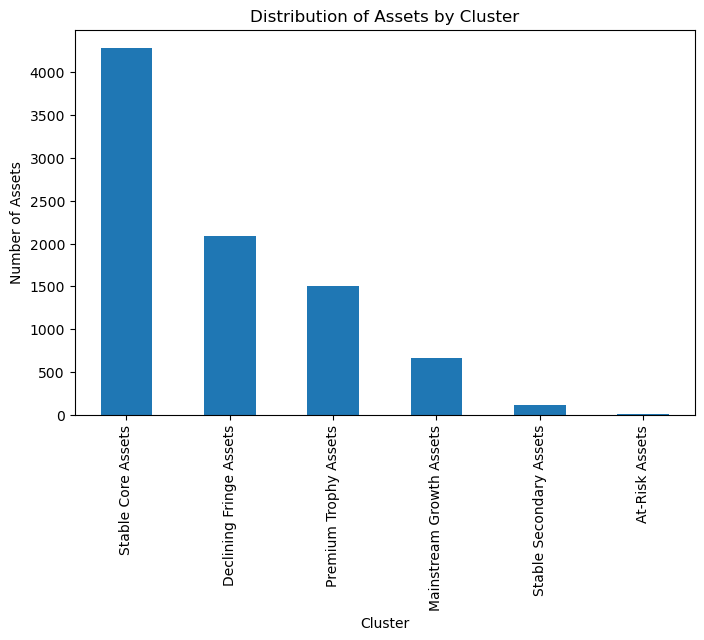


Business guidance:
Cluster 0 - Mainstream Growth Assets | n=665 | avg_pps=657 | avg_12m_pctchg=-0.002
  Suggested: Expand/upgrade selectively, optimize utilization
Cluster 1 - Stable Core Assets | n=4283 | avg_pps=84 | avg_12m_pctchg=0.021
  Suggested: Keep as reliable cashflow generators
Cluster 2 - Premium Trophy Assets | n=1498 | avg_pps=126 | avg_12m_pctchg=0.002
  Suggested: Hold/Invest, prestige value, raise rents, long-term retention
Cluster 3 - Declining Fringe Assets | n=2092 | avg_pps=86 | avg_12m_pctchg=-0.037
  Suggested: Candidate for divestment or redevelopment
Cluster 4 - At-Risk Assets | n=5 | avg_pps=173959 | avg_12m_pctchg=-0.001
  Suggested: Watchlist, improve efficiency or consider divestment
Cluster 5 - Stable Secondary Assets | n=109 | avg_pps=49 | avg_12m_pctchg=-0.046
  Suggested: Maintain, low risk, but not priority for capex


In [12]:
# ============ PROFILE CLUSTERS ============
agg_cols = {
    'pps_asset':'mean','pps_premium_pct':'mean','pct_chg_12m':'mean',
    'log_rentable_sqft':'mean','age':'mean','utilization':'mean','is_owned':'mean',
    'nearest_dist_km':'mean'
}
cluster_profile = df_clean.groupby('macro_cluster').agg(agg_cols).reset_index()
cluster_profile['n_assets'] = df_clean.groupby('macro_cluster').size().values

# --- Fixed business-friendly names ---
cluster_name_map = {
    0: "Mainstream Growth Assets",
    1: "Stable Core Assets",
    2: "Premium Trophy Assets",
    3: "Declining Fringe Assets",
    4: "At-Risk Assets",
    5: "Stable Secondary Assets"
}
cluster_profile['cluster_name'] = cluster_profile['macro_cluster'].map(cluster_name_map)
df_clean['cluster_name'] = df_clean['macro_cluster'].map(cluster_name_map)

# save cluster assignment
df_clean.to_csv(OUT_CSV, index=False)
print('Saved cluster assignments to', OUT_CSV)

# print profile
print('\nCluster profiles:')
print(cluster_profile[['macro_cluster','cluster_name','n_assets','pps_asset','pct_chg_12m']])

# ============ HISTOGRAM ============
plt.figure(figsize=(8,5))
df_clean['cluster_name'].value_counts().plot(kind='bar')
plt.title("Distribution of Assets by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Assets")
plt.show()

# ============ BUSINESS IMPACT ============
print('\nBusiness guidance:')
for _, r in cluster_profile.sort_values('macro_cluster').iterrows():
    print(f"Cluster {r['macro_cluster']} - {r['cluster_name']} | n={int(r['n_assets'])} | "
          f"avg_pps={r['pps_asset']:.0f} | avg_12m_pctchg={r['pct_chg_12m']:.3f}")
    if r['cluster_name']=="Premium Trophy Assets":
        print('  Suggested: Hold/Invest, prestige value, raise rents, long-term retention')
    elif r['cluster_name']=="Mainstream Growth Assets":
        print('  Suggested: Expand/upgrade selectively, optimize utilization')
    elif r['cluster_name']=="Stable Core Assets":
        print('  Suggested: Keep as reliable cashflow generators')
    elif r['cluster_name']=="Stable Secondary Assets":
        print('  Suggested: Maintain, low risk, but not priority for capex')
    elif r['cluster_name']=="Declining Fringe Assets":
        print('  Suggested: Candidate for divestment or redevelopment')
    elif r['cluster_name']=="At-Risk Assets":
        print('  Suggested: Watchlist, improve efficiency or consider divestment')

Note: you may need to restart the kernel to use updated packages.


<Figure size 1000x800 with 0 Axes>

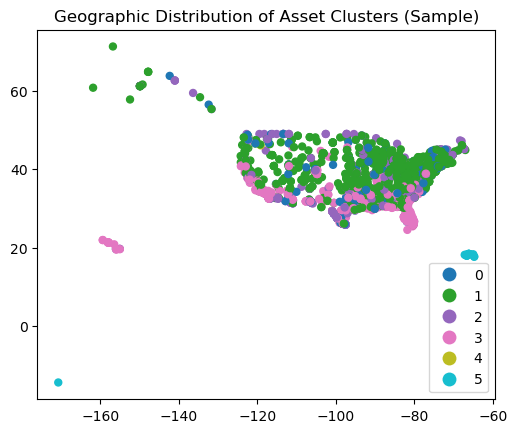

In [13]:
# Install geopandas if not already installed
%pip install geopandas

import geopandas as gpd

# sample 2000 points for clearer plotting
sample = df_clean.sample(n=min(2000, len(df_clean)), random_state=42)
gdf = gpd.GeoDataFrame(sample, geometry=gpd.points_from_xy(sample['longitude'], sample['latitude']))

plt.figure(figsize=(10,8))
gdf.plot(column='macro_cluster', categorical=True, legend=True, markersize=25)
plt.title("Geographic Distribution of Asset Clusters (Sample)")
plt.show()

In [14]:
import pandas as pd
from GeeseTools import DataPreProcessor as dpp

ModuleNotFoundError: No module named 'GeeseTools'

In [ ]:
df = pd.read_csv("data/rwap25_gis_dataset_merged.csv")

In [ ]:
# Optional ID/context columns to carry through each slice (no mutation)
id_cols = [
    "asset_index"
]

In [ ]:
obj = dpp(df, id_cols)
x_train, x_test, y_train, y_test = obj.pre_process()

In [ ]:
features = pd.concat([x_train, x_test])
target = pd.concat([y_train, y_test])
Working_df = pd.concat([features, target], axis=1)  # column-wise
df = Working_df

In [ ]:

# Pillar-specific columns (use exactly as provided; no feature engineering)
price_region_cols = [
    "price_latest", "price_latest_date",
    "nearest_region_price", "nearest_region_price_navg",
    "price_latest_reg", "price_avg_3m", "price_avg_6m", "price_avg_12m",
    "pct_chg_1m", "pct_chg_3m", "pct_chg_12m",
    "vol_6m", "vol_12m", "trend_6m", "trend_12m",
    # optional helpful context keys that often pair with pricing
    "source", "estimated_price"
]

In [ ]:

location_intel_cols = [
    # coordinates (both variants kept as-is)
    "latitude", "longitude", "asset_lat", "asset_lon",
    # admin/geography context
    "regionid", "gsa region", "unified_state", "state_source", "state", "city",
    "countyname", "zip", "zip_raw", "zip_std",
    # Zillow-style region descriptors if present
    "RegionID", "RegionName", "RegionType", "Metro", "CountyName", "City", "State",
    # nearest metro/region context
    "nearest_region_lat", "nearest_region_lon", "nearest_region_metro",
    "nearest_region_county", "nearest_region_city", "nearest_region_state",
    "nearest_region_zip", "nearest_region_index",
    "nearest_dist_km",
    # address lines (kept for mapping/debug, still no transforms)
    "street address", "zip code", "congressional district",
    "congressional district representative name"
]

In [ ]:

dev_status_cols = [
    "real property asset type", "building status", "owned or leased",
    "construction date"
]

In [ ]:
size_util_cols = [
    "building rentable square feet", "available square feet"
]

In [ ]:
profiling_only_cols = [
    "target_price", "predicted_price_model", "used_for_training"
]

In [ ]:

# Helper: select only columns that exist (no re-naming, no casting)
def select_existing(df, cols):
    return [c for c in cols if c in df.columns]

# Build pillar DataFrames (with IDs prefixed where available)
df_price_region = df[select_existing(df, id_cols + price_region_cols)].copy()
df_location_intel = df[select_existing(df, id_cols + location_intel_cols)].copy()
df_dev_status = df[select_existing(df, id_cols + dev_status_cols)].copy()
df_size_util = df[select_existing(df, id_cols + size_util_cols)].copy()
df_profiling = df[select_existing(df, id_cols + profiling_only_cols)].copy()

# Optional: collect in a dict for convenient access
pillar_dfs = {
    "price_region": df_price_region,
    "location_intelligence": df_location_intel,
    "development_status": df_dev_status,
    "size_utilization": df_size_util,
    "profiling_only": df_profiling,
}

# # Quick visibility (no mutations)
for name, dfx in pillar_dfs.items():
    print(f"{name}: shape={dfx.shape}, columns={list(dfx.columns)}")

# Example access:
# df_price_region.head(2)
# df_location_intel.head(2)
# df_dev_status.head(2)
# df_size_util.head(2)
# df_profiling.head(2)

# Optional (commented): save each slice without altering data
# for name, dfx in pillar_dfs.items():
#     dfx.to_csv(f"outputs/{name}.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def KMeansCompat(n_clusters, random_state=42):
    try:
        return KMeans(n_clusters=n_clusters, random_state=random_state, n_init="auto")
    except TypeError:
        return KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)


In [ ]:

def eval_and_pick_k(X, k_range=range(3, 9), random_state=42):
    rows = []
    n = X.shape[0]
    # K must be at least 2 and less than number of samples
    valid_ks = [k for k in k_range if 1 < k < n]
    for k in valid_ks:
        km = KMeansCompat(k, random_state)
        labels = km.fit_predict(X)
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
        try:
            ch = calinski_harabasz_score(X, labels)
        except Exception:
            ch = np.nan
        try:
            db = davies_bouldin_score(X, labels)
        except Exception:
            db = np.nan
        rows.append({"k": k, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})
    m = pd.DataFrame(rows)
    m_valid = m.dropna(subset=["silhouette"])
    if m_valid.empty:
        # fallback default
        return 4, m
    best = m_valid[m_valid["silhouette"] == m_valid["silhouette"].max()]
    best = best[best["calinski_harabasz"] == best["calinski_harabasz"].max()]
    best_row = best.sort_values(["davies_bouldin", "k"], ascending=[True, True]).iloc[0]
    return int(best_row["k"]), m


In [ ]:
cluster_reports = {}

for pillar_name, dfx in pillar_dfs.items():
    X = dfx.select_dtypes(include="number").copy()        # numeric columns only
    X = X.loc[:, X.nunique(dropna=True) > 1]              # drop constant cols
    X = X.dropna(axis=0)                                  # drop rows with NaNs
    n_rows, n_cols = X.shape
    if n_rows < 10 or n_cols == 0:
        print(f"Skip {pillar_name}: insufficient data -> rows={n_rows}, cols={n_cols}")
        continue
    best_k, metrics_tbl = eval_and_pick_k(X.values, k_range=range(3, 9), random_state=42)
    km = KMeansCompat(best_k, random_state=42).fit(X.values)
    labels = pd.Series(km.labels_, index=X.index, name=f"cluster_{pillar_name}")
    pillar_dfs[pillar_name] = dfx.join(labels)             # add cluster labels aligned by index
    cluster_reports[pillar_name] = {
        "best_k": best_k,
        "metrics": metrics_tbl
    }
    print(f"{pillar_name}: best_k={best_k}, rows={n_rows}, features={n_cols}")


In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

for pillar_name, dfx in pillar_dfs.items():
    X = dfx.select_dtypes(include="number").copy().dropna(axis=0)
    n_rows, n_cols = X.shape
    if n_rows < 2 or n_cols == 0:
        print(f"Skipping dendrogram for {pillar_name}: insufficient data")
        continue

    Z = linkage(X, method='ward')  # Ward's linkage (minimize variance within clusters)

    plt.figure(figsize=(10, 4))
    plt.title(f"Dendrogram for '{pillar_name}'")
    plt.xlabel("Sample index")
    plt.ylabel("Distance (Ward linkage)")
    dendrogram(Z, no_labels=True, color_threshold=None)
    plt.tight_layout()
    plt.show()
